# Training on 25,000 events. Testing on the RAMP set.

In [1]:
!nvidia-smi

Fri Aug 25 16:51:09 2017       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 375.66                 Driver Version: 375.66                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1080    Off  | 0000:04:00.0     Off |                  N/A |
| 27%   27C    P8     9W / 180W |    633MiB /  8114MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 1080    Off  | 0000:05:00.0     Off |                  N/A |
| 27%   28C    P8     9W / 180W |      2MiB /  8114MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "7"
%matplotlib notebook
import importlib
import numpy as np
import pandas as pd
import pickle as pk
import keras
from keras.preprocessing.sequence import pad_sequences
from keras.layers import TimeDistributed, Dense, Dropout, GRU, Bidirectional
from keras.models import Sequential
from tracker import extractor as ext, utils, metrics, visuals

Using Theano backend.
Using cuDNN version 5110 on context None
Mapped name None to device cuda: GeForce GTX 1080 (0000:0E:00.0)


### Load in the data.

In [3]:
%%time
modelpath   = "data/models/UNIF-10N-25T-1000E-235R.h5"
trainpath   = "data/sets/UNIF-10N-25T-1000E-235R.gz"
testpath    = "data/sets/RAMP-10N-25T-235R.gz"
train_frame = pd.read_csv(trainpath)
test_frame  = pd.read_csv(testpath)
train       = utils.list_of_groups(train_frame, group="event_id")
test        = utils.list_of_groups(test_frame,  group="event_id")
print("Train is list of {} events.".format(len(train)))
print("Test is list of {} events.".format(len(test)))
if (not utils.is_prepared(train_frame)) or (not utils.is_prepared(test_frame)):
    print("Warning: frame is not prepared.")
    print("Look at the prepare_frame() function in tracker/extractor.py")  

Train is list of 25000 events.
Test is list of 3600 events.
CPU times: user 10.6 s, sys: 316 ms, total: 10.9 s
Wall time: 10.9 s


In [4]:
order = ["phi", "r", "z"]

### Show an example of the data.

Train 8881
Number of Hits: 87
Number of Tracks: 9


<IPython.core.display.Javascript object>


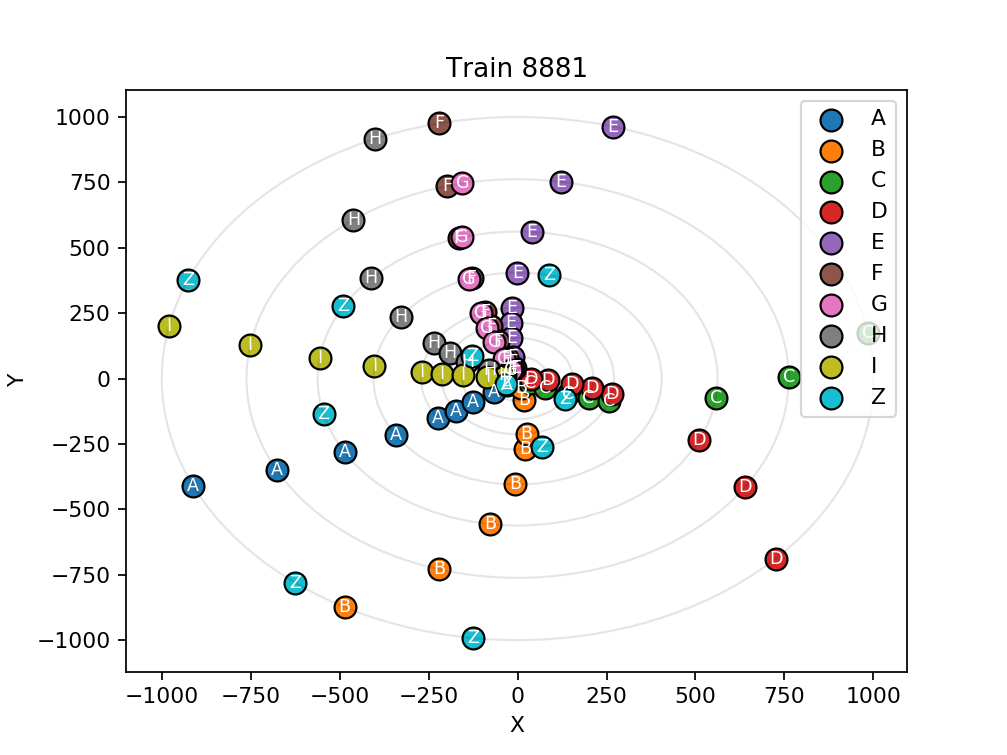

In [5]:
n = 8881 #np.random.randint(len(train))
print("Train {}".format(n))
print("Number of Hits: {}".format(metrics.number_of_hits(train[n])))
print("Number of Tracks: {}".format(metrics.number_of_tracks(train[n])))
visuals.Plot2D(train[n], order).plot(mode="xy", title="Train {}".format(n))

In [6]:
print(n)
visuals.display(train[n], order)

8881


phi       r           z  A  B  C  D  E  F  G  H  I J K L M N O P Q  \
0   -2.895529   562.0  -80.662152                                              
1   -2.719777  1000.0  -48.289718  1                                           
2   -2.663688   762.0  -36.796765  1                                           
3   -2.615846   562.0  -27.138822  1                                           
4   -2.577248   405.0  -19.557336  1                                           
5   -2.546779    39.0  117.754959                                              
6   -2.543667   271.0  -13.086514  1                                           
7   -2.527406   213.0  -10.285710  1                                           
8   -2.509782   155.0   -7.484906  1                                           
9   -2.485555    85.0   -4.104626  1                                           
10  -2.462780    39.0   -1.883299  1                                           
11  -2.245650  1000.0  -60.267437                                              
12  -2.077891  1000.0  114.600548     1                                        
13  -1.863848   762.0   87.325618     1                                        
14  -1.709420   562.0   64.405508     1                                        
15  -1.696002  1000.0  -54.406171                                              
16  -1.589613   405.0   46.413222     1                                        
17  -1.493245   271.0   31.056749     1                                        
18  -1.451326   213.0   24.409917     1                                        
19  -1.354118    85.0    9.741047     1                                        
20  -1.315789   271.0  120.568961                                              
21  -1.305687    39.0    4.469421     1                                        
22  -0.759434  1000.0   57.753164           1                                  
23  -0.573819   762.0   44.007911           1                                  
24  -0.533374   155.0 -121.914131                                              
25  -0.489588    39.0    1.612450        1                                     
26  -0.448208    85.0    3.514315        1                                     
27  -0.430323   562.0   32.457278           1                                  
28  -0.398832   155.0    6.408457        1                                     
29  -0.360300   213.0    8.806460        1                                     
30  -0.320734   271.0   11.204463        1                                     
31  -0.220532   271.0   15.651108           1                                  
32  -0.177887   213.0   12.301424           1                                  
33  -0.134616   155.0    8.951740           1                                  
34  -0.129868   562.0   23.235824        1                                     
35  -0.081669    85.0    4.909019           1                                  
36  -0.025436    39.0    2.252373           1                                  
37   0.005293   762.0   31.504800        1                                     
38   0.174972  1000.0   41.344882        1                                     
39   1.298969  1000.0  152.800193              1                               
40   1.352023   405.0   13.358846                                              
41   1.410496   762.0  116.433747              1                               
42   1.500281   562.0   85.873708              1                               
43   1.572882   405.0   61.884078              1                               
44   1.632537   271.0   41.408852              1                               
45   1.659197   213.0   32.546441              1                               
46   1.685485   155.0   23.684030              1                               
47   1.715823    85.0   12.988016              1                               
48   1.734821    39.0    5.959208              1                               
49   1.775

### Create the model.

In [7]:
input_shape  = (235, 3)
n_categories = 25 + 2
optimizer    = keras.optimizers.RMSprop(lr=0.001)
histories    = []

model = Sequential()
model.add(Bidirectional(
    GRU(units=256, return_sequences=True, recurrent_dropout=1/2, implementation=2),
    merge_mode="mul",
    input_shape=input_shape))
model.add(Dropout(rate=1/2))
model.add(Bidirectional(
    GRU(units=256, return_sequences=True, recurrent_dropout=1/2, implementation=2),
    merge_mode="mul"))
model.add(Dropout(rate=1/2))
model.add(Bidirectional(
    GRU(units=256, return_sequences=True, recurrent_dropout=1/2, implementation=2),
    merge_mode="mul"))
model.add(Dropout(rate=1/2))
model.add(TimeDistributed(Dense(units=n_categories, kernel_initializer="uniform", activation="softmax")))
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 235, 256)          399360    
_________________________________________________________________
dropout_1 (Dropout)          (None, 235, 256)          0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 235, 256)          787968    
_________________________________________________________________
dropout_2 (Dropout)          (None, 235, 256)          0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 235, 256)          787968    
_________________________________________________________________
dropout_3 (Dropout)          (None, 235, 256)          0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 235, 27)           6939      
Total para

### Fit the model.

In [8]:
%%time
epochs     = 32
batch_size = 100
histories.append(model.fit_generator(
    ext.input_output_generator(train, batch_size, order),
    steps_per_epoch=len(train) // batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=ext.input_output_generator(test, batch_size, order),
    validation_steps=len(test) // batch_size,
    callbacks=[
        keras.callbacks.ModelCheckpoint(
            filepath=modelpath,
            save_best_only=True,
            verbose=0,)]))

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


Epoch 1/32
250/250 [==============================] - 368s - loss: 1.5125 - acc: 0.5867 - val_loss: 0.6106 - val_acc: 0.7716
Epoch 2/32
250/250 [==============================] - 356s - loss: 1.0112 - acc: 0.6438 - val_loss: 0.5442 - val_acc: 0.7878
Epoch 3/32
250/250 [==============================] - 357s - loss: 0.9250 - acc: 0.6684 - val_loss: 0.6294 - val_acc: 0.7438
Epoch 4/32
250/250 [==============================] - 356s - loss: 0.8474 - acc: 0.6887 - val_loss: 0.5002 - val_acc: 0.7942
Epoch 5/32
250/250 [==============================] - 356s - loss: 0.7780 - acc: 0.7156 - val_loss: 0.4017 - val_acc: 0.8605
Epoch 6/32
250/250 [==============================] - 354s - loss: 0.7257 - acc: 0.7339 - val_loss: 0.3692 - val_acc: 0.8769
Epoch 7/32
250/250 [==============================] - 355s - loss: 0.6740 - acc: 0.7556 - val_loss: 0.3374 - val_acc: 0.8903
Epoch 8/32
250/250 [==============================] - 355s - loss: 0.6386 - acc: 0.7710 - val_loss: 0.3230 - val_acc: 0.8941


### Display information about the model after fitting it.

In [19]:
%%time
guesses          = model.predict(ext.extract_input(test, order))
hits_correct     = metrics.percent_of_hits_assigned_correctly(test, guesses=guesses, order=order)
tracks_correct   = metrics.percent_of_tracks_assigned_correctly(test, guesses=guesses, order=order, percent=1.0)
n_tracks_correct = metrics.percent_of_events_with_correct_number_of_tracks(test, guesses=guesses, order=order)
print("Percent of hits assigned correctly: {}%".format(hits_correct * 100))
print("Percent of tracks assigned correctly: {}%".format(tracks_correct * 100))
print("Percent of events with the correct number of tracks: {}%".format(n_tracks_correct * 100))

Percent of hits assigned correctly: 83.76375362844159%
Percent of tracks assigned correctly: 0.0%
Percent of events with the correct number of tracks: 80.69444444444444%
CPU times: user 1min 37s, sys: 64 ms, total: 1min 37s
Wall time: 1min 37s


### Display how one of the model's predictions looks.

Percent of hits assigned correctly: 85.91549295774648%


<IPython.core.display.Javascript object>


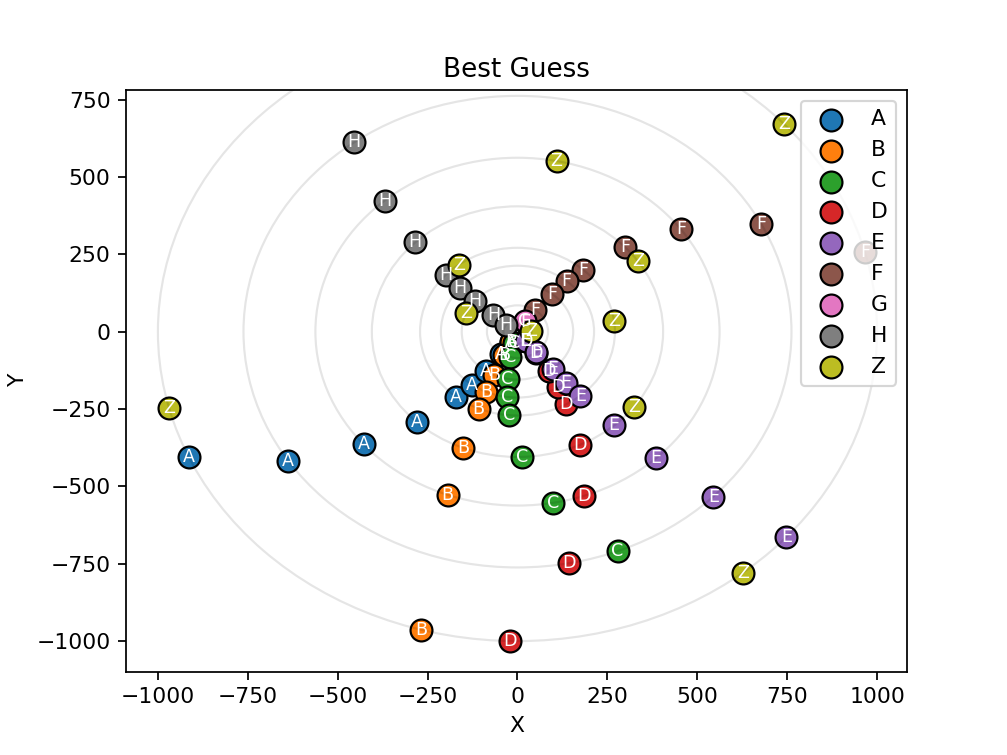

<IPython.core.display.Javascript object>


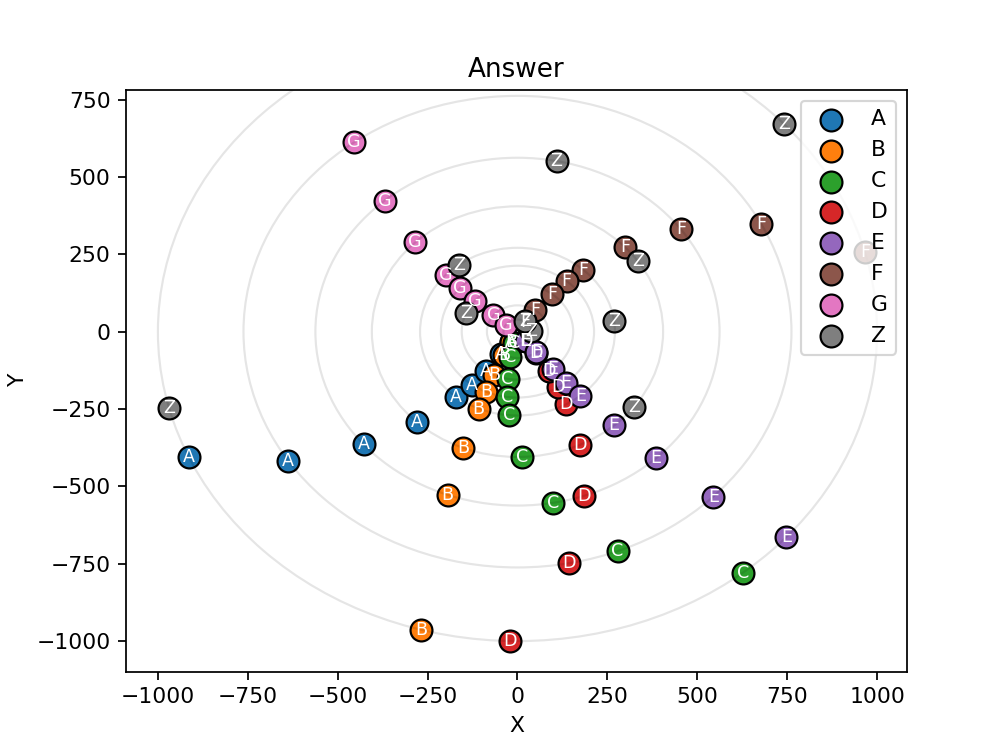

In [20]:
n  = 6
hc = metrics.percent_of_hits_assigned_correctly(test[n], guesses[n], order=order)
print("Percent of hits assigned correctly: {}%".format(hc * 100))
d = visuals.Plot2D(test[n], order, guesses[n]).plot(mode="xy", title="Best Guess")
d = visuals.Plot2D(test[n], order).plot(mode="xy", title="Answer")

In [21]:
visuals.display(test[n], order, guesses[n], mode="discrete pairs")

phi       r           z         A         B         C         D  \
0   -2.891611  1000.0    0.378714                                           
1   -2.725844  1000.0 -158.601398  `1`[1.0]                                 
2   -2.562788   762.0 -120.854266  `1`[1.0]                                 
3   -2.435731   562.0  -89.133986  `1`[1.0]                                 
4   -2.335917   405.0  -64.233566  `1`[1.0]                                 
5   -2.249899   271.0  -42.980979  `1`[1.0]                                 
6   -2.210670   213.0  -33.782098  `1`[1.0]                                 
7   -2.174663   155.0  -24.583217  `1`[1.0]                                 
8   -2.127336    85.0  -13.481119  `1`[1.0]                                 
9   -2.082002    39.0   -6.185455  `1`[1.0]                                 
10  -2.039696    39.0   -5.891548            `1`[1.0]                       
11  -2.021455    85.0  -12.840553            `1`[1.0]                       
12  -2.003697   155.0  -23.415125            `1`[1.0]                       
13  -1.991187   213.0  -32.176914            `1`[1.0]                       
14  -1.979051   271.0  -40.938703            `1`[1.0]                       
15  -1.953696   405.0  -61.181456            `1`[1.0]                       
16  -1.923816   562.0  -84.898712            `1`[1.0]                       
17  -1.841196  1000.0 -151.065324            `1`[1.0]                       
18  -1.840982    39.0    1.154462                      `1`[1.0]             
19  -1.801456    85.0    2.516135                      `1`[1.0]             
20  -1.749021   155.0    4.588246                      `1`[1.0]             
21  -1.708794   213.0    6.305138                      `1`[1.0]             
22  -1.659680   271.0    8.022031                      `1`[1.0]             
23  -1.590596  1000.0  -91.658915                                `1`[1.0]   
24  -1.539377   405.0   11.988644                      `1`[1.0]             
25  -1.393842   562.0   16.636093                      `1`[1.0]             
26  -1.382345   762.0  -69.844093                                `1`[1.0]   
27  -1.233612   562.0  -51.512310                                `1`[1.0]   
28  -1.196978   762.0   22.556411                      `1`[1.0]             
29  -1.129008   405.0  -37.121861                                `1`[1.0]   
30  -1.045383   271.0  -24.839566                                `1`[1.0]   
31  -1.008446   213.0  -19.523349                                `1`[1.0]   
32  -0.967897   155.0  -14.207132                                `1`[1.0]   
33  -0.929110    85.0   -7.791008                                `1`[1.0]   
34  -0.915363    39.0   -3.574698                                `1`[1.0]   
35  -0.900620    39.0   -4.735923                                           
36  -0.899993    85.0  -10.321883                                           
37  -0.893998  1000.0   29.601589                      `1`[0.0]             
38  -0.891123   155.0  -18.822258                                           
39  -0.881451   213.0  -25.865425                                           
40  -0.870661   271.0  -32.908593                                           
41  -0.845305   405.0  -49.180738                                           
42  -0.814668   562.0  -68.245864                                           
43  -0.774342   762.0  -92.532648                                           
44  -0.726348  1000.0 -121.433921                                           
45  -0.640971   405.0 -132.991943                                           
46   0.080004    39.0 -113.637570                                           
47   0.123974   271.0 -145.825605                                           
48   0.259649  1000.0 -149.399262                                           
49   0.474080   762.0 -113.842238                                           
50   0.596675   405.0 -118.781257                                           
51   0